In [1]:
# For a jupyter notebook add the following line:
%matplotlib inline

# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt

import pandas as pd
from scipy.fft import fft

In [2]:
import mesa
import math
import numpy as np

# /*** CONFIG SECTION ***/

# Number of persons in household - approx percentage for 1,2...7 people in USA - from Statista
houseshold_sizes = [1,2,3,4,5,6,7]
houseshold_size_distribution = [0.28,0.36,0.15,0.12,0.06,0.02,0.01]

# Consumption rate: number of steps per person neded to consume 1 product
# E.g. a consumption rate of 3 means that a product is consumed by one person in 3 steps
# Concretely, that could mean a tube of toothpaste takes 3 weeks to use per person
# Consumption rates are defined statistically via absolute value of a normal distribution
base_consumption_rate = 3

# Base product price
base_product_price = 5

# Buying behaviors
buying_behaviors = ["buy_minimum", "buy_maximum", "buy_some_or_none", "buy_none"]

def get_pantry_max(household_size, pantry_min):
    pantry_max = math.ceil(np.random.normal(household_size,1))
    if pantry_max < pantry_min:
        pantry_max = pantry_min
    return pantry_max

def get_current_price(base_price, promo_depths=[1, 0.75, 0.5], promo_frequencies=[0.5, 0.25, 0.25]):
    '''
    base_price: unitless number ("1" could be 1 dollar, 1 euro, etc.) 
    promo_depths: list of percentage discounts to be take off base 
    promo_frequencies: list of probabilities reflecting percentage of occasions depth will be applied
    
    Example: get_current_price(4.99, promo_depths=[1, 0.75, 0.5], promo_frequencies=[0.5,0.25,0.25])
    
    Above example will return a price that is 4.99 50% of the time, 3.74 and 2.50 25% of the time
    '''
    
    promo_depth = np.random.choice(promo_depths, p=promo_frequencies)
    current_price = base_price * promo_depth
    return current_price

def compute_total_purchases(model):
    purchases = [agent.purchased_this_step for agent in model.schedule.agents]
    return sum(purchases)

def compute_average_price(model):
    prices = [agent.last_product_price for agent in model.schedule.agents]
    return np.mean(prices)

class ConsumerAgent(mesa.Agent):
    """Consumer of products"""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.household_size = np.random.choice(houseshold_sizes, p=houseshold_size_distribution)
        self.consumption_rate = abs(np.random.normal(base_consumption_rate,1)) # Applied at household level
        self.pantry_min = math.ceil(self.household_size * 0.5) # Forces must-buy when stock drops below half (0.5) household size
        self.pantry_max = get_pantry_max(self.household_size, self.pantry_min)
        self.pantry_stock = self.pantry_max
        self.purchased_this_step = 0
        self.current_price = get_current_price(base_product_price)
        self.last_product_price = get_current_price(base_product_price)
        self.purchase_behavior = "buy_minimum"
        self.step_min = 0

    def consume(self):
        self.pantry_stock = (self.pantry_stock - self.household_size/self.consumption_rate)
        
    # Need to define a parametric model for purchase behavior and price sensitivity
    def set_purchase_behavior(self):
        self.current_price = get_current_price(base_product_price)
        if self.pantry_stock <= self.pantry_min:
            if self.current_price >= base_product_price:
                self.purchase_behavior = "buy_minimum"
            elif self.current_price < self.last_product_price: # not great, should allow for more nuanced spending in this regime
                self.purchase_behavior = "buy_maximum"
            else:
                self.purchase_behvaior = "buy_minimum" # redundant but specific for all cases
        elif self.pantry_min < self.pantry_stock < self.pantry_max:
            if self.current_price >= base_product_price:
                self.purchase_behavior = "buy_some_or_none"
            elif self.current_price < self.last_product_price:
                self.purchase_behavior = "buy_maximum"
            else:
                self.purchase_behavior = "buy_some_or_none"
        elif self.pantry_stock >= self.pantry_max:
            self.purchase_behavior = "buy_none"
        self.last_product_price = self.current_price
           
    
    def purchase(self):
        self.purchased_this_step = 0 # Reset purchase count
        self.step_min = math.ceil(self.pantry_min - self.pantry_stock)
        # *** safety check for step_min - need a better test/catch
        if self.step_min < 0:
            self.step_min = 0
        # ***
        step_max = math.floor(self.pantry_max - self.pantry_stock)
        if self.purchase_behavior == "buy_minimum":
            self.purchased_this_step += self.step_min
        elif self.purchase_behavior == "buy_maximum":
            self.purchased_this_step += step_max
        elif self.purchase_behavior == "buy_some_or_none": # include 0 as a possible purchase even if pantry not full
            self.purchased_this_step += np.random.choice(list(range(0, (step_max + 1))))
        elif self.purchase_behavior == "buy_none":
            self.purchased_this_step += 0 # redundant but specific
        self.pantry_stock += self.purchased_this_step
                    
    
#     def shop(self):
#         self.purchased_this_step = 0 # Reset purchase count
#         # Blind restock - no choices or price sensitivity
#         if self.pantry_stock < self.pantry_max:
#             self.purchased_this_step += math.floor(self.pantry_max - self.pantry_stock)
#         self.pantry_stock += self.purchased_this_step
        
    
    def step(self):
        self.consume()
        #self.shop()
        self.set_purchase_behavior()
        self.purchase()
        
class ConsumerModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N):
        self.num_agents = N
        self.schedule = mesa.time.RandomActivation(self)
        
        # Create agents
        for i in range(self.num_agents):
            a = ConsumerAgent(i, self)
            self.schedule.add(a)
        
        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Total_Purchases": compute_total_purchases,
                "Average_Product_Price": compute_average_price
            },
            agent_reporters={
                "Household_Size": "household_size",
                "Purchased_This_Step": "purchased_this_step",
                "Pantry_Stock": "pantry_stock",
                "Pantry_Max": "pantry_max",
                "Pantry_Min": "pantry_min",
                "Purchase_Behavior": "purchase_behavior",
                "Minimum_Purchase_Needed": "step_min",
                "Current_Product_Price": "current_price",
                "Last_Produce_Price": "last_product_price"
                
            }
        )

    def step(self):
        self.datacollector.collect(self)
        """Advance the model by one step and collect data"""
        self.schedule.step()

In [3]:
model = ConsumerModel(1000)

for i in range(100):
    model.step()

In [4]:
model_summary_df = model.datacollector.get_model_vars_dataframe()

In [5]:
model_summary_df.iloc[10:]

,Total_Purchases,Average_Product_Price
10,1084,4.05250
11,1048,4.06500
12,1069,4.05625
13,1061,4.11375
14,1091,4.06250
...,...,...
95,1066,4.08875
96,1079,4.14250
97,1061,4.04625
98,1074,4.05250


In [6]:
agent_summary_df = model.datacollector.get_agent_vars_dataframe()

In [30]:
agent_summary_df

Household_Size  Purchased_This_Step  Pantry_Stock  Pantry_Max  \
Step AgentID                                                                  
0    0                     6                    0      4.000000           4   
     1                     3                    0      2.000000           2   
     2                     2                    0      3.000000           3   
     3                     4                    0      4.000000           4   
     4                     3                    0      3.000000           3   
...                      ...                  ...           ...         ...   
99   995                   2                    1      1.798535           2   
     996                   2                    1      2.476925           3   
     997                   2                    0      0.499506           1   
     998                   1                    0      1.602651           1   
     999                   2                    1      1.465558           2   

              Pantry_Min Purchase_Behavior  Minimum_Purchase_Needed  \
Step AgentID                                                          
0    0                 3       buy_minimum                        0   
     1                 2       buy_minimum                        0   
     2                 1       buy_minimum                        0   
     3                 2       buy_minimum                        0   
     4                 2       buy_minimum                        0   
...                  ...               ...                      ...   
99   995               1       buy_maximum                        1   
     996               1       buy_maximum                        0   
     997               1       buy_maximum                        1   
     998               1          buy_none                        0   
     999               1       buy_minimum                        1   

              Current_Product_Price  Last_Produce_Price  
Step AgentID                                             
0    0                         5.00                2.50  
     1                         2.50                5.00  
     2                         3.75                3.75  
     3                         5.00                2.50  
     4                         2.50                3.75  
...                             ...                 ...  
99   995                       3.75                3.75  
     996                       2.50                2.50  
     997                       3.75                3.75  
     998                       2.50                2.50  
     999                       5.00                5.00  

[100000 rows x 9 columns]

In [31]:
agent_2 = agent_summary_df.xs(2,level="AgentID")

<Axes: >

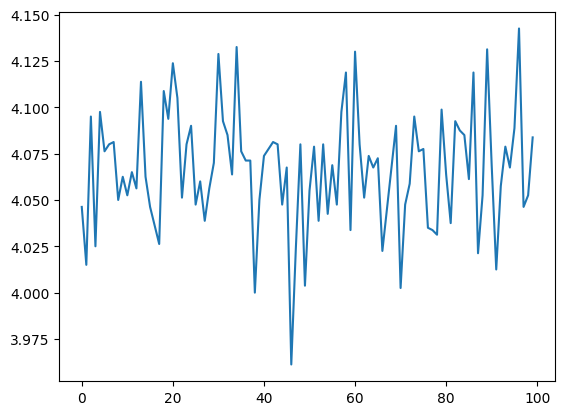

In [14]:
model_summary_df['Average_Product_Price'].plot()

In [15]:
import seaborn as sns

<Axes: xlabel='Current_Product_Price', ylabel='Purchased_This_Step'>

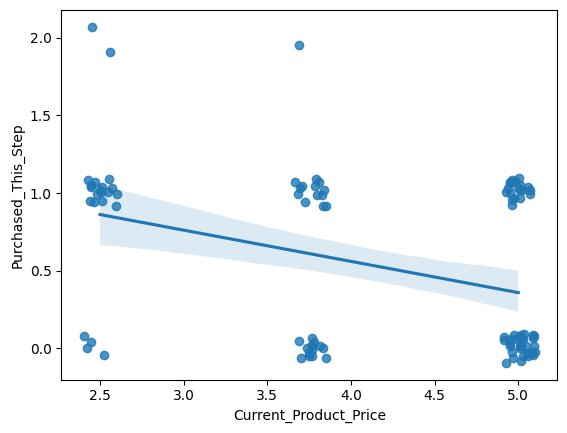

In [32]:
sns.regplot(data=agent_2,x='Current_Product_Price',y='Purchased_This_Step',x_jitter=0.1,y_jitter=0.1)

In [17]:
import statsmodels.api as sm

In [18]:
import statsmodels.formula.api as smf

In [23]:
mod = smf.ols(formula='Purchased_This_Step ~ Current_Product_Price', data=agent_3)

In [24]:
res = mod.fit()

In [25]:
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     Purchased_This_Step   R-squared:                       0.165
Model:                             OLS   Adj. R-squared:                  0.156
Method:                  Least Squares   F-statistic:                     19.32
Date:                 Wed, 01 Mar 2023   Prob (F-statistic):           2.81e-05
Time:                         19:44:47   Log-Likelihood:                -113.99
No. Observations:                  100   AIC:                             232.0
Df Residuals:                       98   BIC:                             237.2
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           

In [21]:
agent_dat = model.datacollector.get_agent_vars_dataframe()

In [22]:
agent_dat.head()

Household_Size  Purchased_This_Step  Pantry_Stock  Pantry_Max  \
Step AgentID                                                                  
0    0                     1                    0           2.0           2   
     1                     1                    0           2.0           2   
     2                     1                    0           1.0           1   
     3                     1                    0           2.0           2   
     4                     1                    0           2.0           2   

              Pantry_Min Purchase_Behavior  Minimum_Purchase_Needed  \
Step AgentID                                                          
0    0                 1       buy_minimum                        0   
     1                 1       buy_minimum                        0   
     2                 1       buy_minimum                        0   
     3                 1       buy_minimum                        0   
     4                 1       buy_minimum                        0   

              Current_Product_Price  Last_Produce_Price  
Step AgentID                                             
0    0                         2.50                5.00  
     1                         3.75                3.75  
     2                         2.50                5.00  
     3                         2.50                5.00  
     4                         5.00                5.00

In [23]:
total_purchases = model.datacollector.get_model_vars_dataframe()['Total_Purchases']
step_index = np.array((range(len(total_purchases))))

In [24]:
total_purchases_FFT = fft(total_purchases)

In [25]:
N = len(total_purchases)

Text(0.5, 0, 'Consumption Rates (steps per product)')

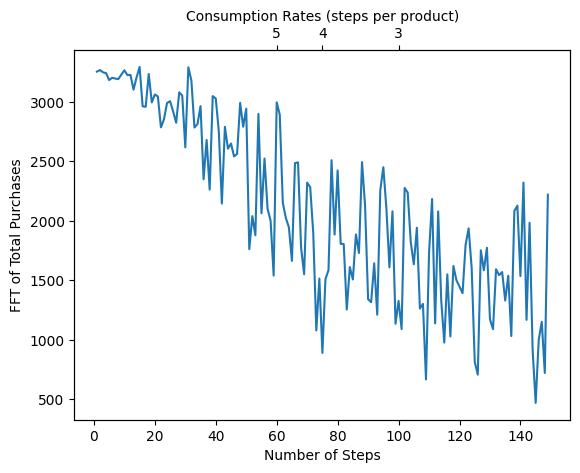

In [26]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(step_index[:N//2][1:],np.abs(total_purchases_FFT[:N//2][1:]))
ax1.set_xlabel(r"Number of Steps")
ax1.set_ylabel(r"FFT of Total Purchases")

new_tick_locations = [300/5,300/4,300/3]
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels([5,4,3])
ax2.set_xlabel(r"Consumption Rates (steps per product)")
